# Advanced  

* MountainCar environment
* Continous state space: position from -1.2 to 0.6 with starting between -0.6 to -0.4; velocity -0.07 to 0.07
* Goal reach pos=0.5
* Success: -110 score in 100 episodes or fail >200steps
* 3 actions: push left, no push, push right

*From Github OpenAI: https://github.com/openai/gym/wiki/MountainCar-v0*


### **Imports**

In [1]:
# Uncomment and download prior to running the code
#!pip install gym==0.26.2

In [2]:
#!pip install tensorflow

In [3]:
import gym as gym
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras as keras
import random
import torch
import typing
import collections
from torch import nn, optim
import torch.nn.functional as F
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.activations import relu, linear
from collections import deque


In [4]:
# Check it's 0.26.2
print(gym.__version__)

0.26.2


In [5]:
# For compatibility with google colab
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

<ipython-input-5-8307410ffab6>:2: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, 'bool8'):


In [6]:
# For reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## **Experiment 1**
* 3 hidden layers: size 12-12-12
* batch_size: 8
* epsilon_decay: 0.995
* alpha: 0.1
* gamma: 0.99
* Episodes: 10,000
* Buffer size: 100,000
* target update frequency: 20
* Optimizer: Adam - lr =0.03

### Experience replay buffer

In [7]:
#Experience replay buffer

_field_names = [
    "state",
    "action",
    "reward",
    "next_state",
    "done"
]
Experience = collections.namedtuple("Experience", field_names=_field_names)

class ExperienceReplayBuffer:

    def __init__(self,
                 batch_size: int,
                 buffer_size: int = None,
                 random_state: np.random.RandomState = None) -> None:

        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer = collections.deque(maxlen=buffer_size)
        self._random_state = np.random.RandomState() if random_state is None else random_state

    def __len__(self) -> int:
        return len(self._buffer)

    @property
    def batch_size(self) -> int:
        return self._batch_size

    @property
    def buffer_size(self) -> int:
        return self._buffer_size

    def append(self, experience: Experience) -> None:
        self._buffer.append(experience)

    def sample(self) -> typing.List[Experience]:
        idxs = self._random_state.randint(len(self._buffer), size=self._batch_size)
        experiences = [self._buffer[idx] for idx in idxs]
        return experiences


### Q-learning update

In [8]:
# Class qnetwork
def select_greedy_actions(states: torch.Tensor, q_network: nn.Module) -> torch.Tensor:
    """Select the greedy action for the current state given some Q-network."""
    _, actions = q_network(states).max(dim=1, keepdim=True)
    return actions


def evaluate_selected_actions(states: torch.Tensor,
                              actions: torch.Tensor,
                              rewards: torch.Tensor,
                              dones: torch.Tensor,
                              gamma: float,
                              q_network: nn.Module) -> torch.Tensor:
    next_q_values = q_network(states).gather(dim=1, index=actions)
    q_values = rewards + (gamma * next_q_values * (1 - dones))
    return q_values


In [9]:
def q_learning_update(states: torch.Tensor,
                      rewards: torch.Tensor,
                      dones: torch.Tensor,
                      gamma: float,
                      q_network: nn.Module) -> torch.Tensor:
    actions = select_greedy_actions(states, q_network)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network)
    return q_values

In [10]:
def double_q_learning_update(states: torch.Tensor,
                             rewards: torch.Tensor,
                             dones: torch.Tensor,
                             gamma: float,
                             q_network_1: nn.Module,
                             q_network_2: nn.Module) -> torch.Tensor:
    actions = select_greedy_actions(states, q_network_1)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network_2)
    return q_values

### Agent class

In [11]:
class Agent:

    def choose_action(self, state: np.array) -> int:
        raise NotImplementedError

    def learn(self, experiences: typing.List[Experience]) -> None:
        raise NotImplementedError

    def save(self, filepath) -> None:
        raise NotImplementedError

    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        raise NotImplementedError

In [12]:
class DeepQAgent(Agent):

    def __init__(self,
                 state_size: int,
                 action_size: int,
                 optimizer_fn: typing.Callable[[typing.Iterable[nn.Parameter]], optim.Optimizer],
                 batch_size: int,
                 buffer_size: int,
                 epsilon_decay_schedule: typing.Callable[[int], float],
                 alpha: float,
                 gamma: float,
                 update_frequency: int,
                 double_dqn: bool = False,
                 seed: int = None) -> None:

        self._state_size = state_size
        self._action_size = action_size
        self._device = torch.device(("mps") if torch.backends.mps.is_available() else torch.device("cpu"))


        self._random_state = np.random.RandomState() if seed is None else np.random.RandomState(seed)
        if seed is not None:
            torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        _replay_buffer_kwargs = {
            "batch_size": batch_size,
            "buffer_size": buffer_size,
            "random_state": self._random_state
        }
        self._memory = ExperienceReplayBuffer(**_replay_buffer_kwargs)
        self._epsilon_decay_schedule = epsilon_decay_schedule
        self._alpha = alpha
        self._gamma = gamma
        self._double_dqn = double_dqn

        # initialize Q-Networks
        self._update_frequency = update_frequency
        self._online_q_network = self._initialize_q_network()
        self._target_q_network = self._initialize_q_network()
        self._synchronize_q_networks(self._target_q_network, self._online_q_network)
        self._online_q_network.to(self._device)
        self._target_q_network.to(self._device)

        # initialize the optimizer
        self._optimizer = optimizer_fn(self._online_q_network.parameters())

        # initialize some counters
        self._number_episodes = 0
        self._number_timesteps = 0

    def _initialize_q_network(self) -> nn.Module:
        q_network = nn.Sequential(
            nn.Linear(in_features=self._state_size, out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12, out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12, out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12, out_features=self._action_size)
        )
        return q_network

    @staticmethod
    def _soft_update_q_network_parameters(q_network_1: nn.Module,
                                          q_network_2: nn.Module,
                                          alpha: float) -> None:
        for p1, p2 in zip(q_network_1.parameters(), q_network_2.parameters()):
            p1.data.copy_(alpha * p2.data + (1 - alpha) * p1.data)

    @staticmethod
    def _synchronize_q_networks(q_network_1: nn.Module, q_network_2: nn.Module) -> None:
        _ = q_network_1.load_state_dict(q_network_2.state_dict())

    def _uniform_random_policy(self, state: torch.Tensor) -> int:
        return self._random_state.randint(self._action_size)

    def _greedy_policy(self, state: torch.Tensor) -> int:
        action = (self._online_q_network(state).argmax().cpu().item())
        return action

    def _epsilon_greedy_policy(self, state: torch.Tensor, epsilon: float) -> int:
        if self._random_state.random() < epsilon:
            action = self._uniform_random_policy(state)
        else:
            action = self._greedy_policy(state)
        return action

# Modified function
    def choose_action(self, state: np.array) -> int:
      if isinstance(state, tuple):
          state = state[0]
      if isinstance(state, np.float32):
          state = np.array([state])
      if not isinstance(state, np.ndarray):
          state = np.array(state, dtype=np.float32)
      if state.ndim == 1:
          state = np.expand_dims(state, axis=0)

      state_tensor = torch.from_numpy(state).float().to(self._device).unsqueeze(0)

      if not self.has_sufficient_experience():
          action = self._uniform_random_policy(state_tensor)
      else:
          epsilon = self._epsilon_decay_schedule(self._number_episodes)
          action = self._epsilon_greedy_policy(state_tensor, epsilon)

      return action

    def learn(self, experiences: typing.List[Experience]) -> None:
        states, actions, rewards, next_states, dones = (torch.Tensor(vs).to(self._device) for vs in zip(*experiences))
        actions = (actions.long().unsqueeze(dim=1))
        rewards = rewards.unsqueeze(dim=1)
        dones = dones.unsqueeze(dim=1)

        if self._double_dqn:
            target_q_values = double_q_learning_update(next_states,
                                                       rewards,
                                                       dones,
                                                       self._gamma,
                                                       self._online_q_network,
                                                       self._target_q_network)
        else:
            target_q_values = q_learning_update(next_states,
                                                rewards,
                                                dones,
                                                self._gamma,
                                                self._target_q_network)

        online_q_values = (self._online_q_network(states)
                               .gather(dim=1, index=actions))

        # Compute loss function
        loss = F.mse_loss(online_q_values, target_q_values)

        # update network parameters
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()

        self._soft_update_q_network_parameters(self._target_q_network,
                                               self._online_q_network,
                                               self._alpha)

    # Check buffer has enough experiences to start sampling
    def has_sufficient_experience(self) -> bool:
        return len(self._memory) >= self._memory.batch_size

    def save(self, filepath: str) -> None:
        checkpoint = {
            "q-network-state": self._online_q_network.state_dict(),
            "optimizer-state": self._optimizer.state_dict(),
            "agent-hyperparameters": {
                "alpha": self._alpha,
                "batch_size": self._memory.batch_size,
                "buffer_size": self._memory.buffer_size,
                "gamma": self._gamma,
                "update_frequency": self._update_frequency
            }
        }
        torch.save(checkpoint, filepath)

    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        experience = Experience(state, action, reward, next_state, done)
        self._memory.append(experience)

        if done:
            self._number_episodes += 1
        else:
            self._number_timesteps += 1

            # Set frequency i.e. number of steps where agent learns from experiences
            if self._number_timesteps % self._update_frequency == 0 and self.has_sufficient_experience():
                experiences = self._memory.sample()
                self.learn(experiences)


### Train

In [13]:
# Max steps training
def _train_for_at_most(agent: Agent, env: gym.Env, max_timesteps: int) -> int:
    state, _= env.reset()
    score = 0
    # Record number of steps taken by the agent
    steps_taken=0
    for t in range(max_timesteps):
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        steps_taken+=1
        if done:
            break
    return score, steps_taken

# Train until current episode
def _train_until_done(agent: Agent, env: gym.Env) -> float:
    state, _= env.reset()
    score = 0
    steps_taken=0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        steps_taken+=1
    return score, steps_taken

In [14]:
def train(agent: Agent,
          env: gym.Env,
          checkpoint_filepath: str,
          target_score: float,
          number_episodes: int,
          maximum_timesteps=None) -> typing.List[float]:
    scores = []
    steps_taken_list=[]
    # 15,000 size of scores deque
    most_recent_scores = collections.deque(maxlen=15000)
    for i in range(number_episodes):
        if maximum_timesteps is None:
            score, steps_taken = _train_until_done(agent, env)
        else:
            score, steps_taken = _train_for_at_most(agent, env, maximum_timesteps)
        scores.append(score)
        steps_taken_list.append(steps_taken)
        most_recent_scores.append(score)

        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if average_score >= target_score:
            print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            agent.save(checkpoint_filepath)
            break
        # Show reward for every 1,000th episode
        if (i + 1) % 1000 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")

    return scores, steps_taken_list

### Epsilon

In [15]:
def power_decay_schedule(episode_number: int,
                         decay_factor: float,
                         minimum_epsilon: float,
                         max_eps: float) -> float:
    return max(max_eps*decay_factor**episode_number, minimum_epsilon)
# Start with epsilon =1.0 and decay by 0.995
_epsilon_decay_schedule_kwargs = {
    "decay_factor": 0.995,
    "minimum_epsilon": 0.1,
    "max_eps": 1.0
}
epsilon_decay_schedule = lambda n: power_decay_schedule(n, **_epsilon_decay_schedule_kwargs)

### Optimizer

In [16]:
_optimizer_kwargs = {
    "lr": 1e-3,
    "betas": (0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0,
    "amsgrad": False,
}
optimizer_fn = lambda parameters: optim.Adam(parameters, **_optimizer_kwargs)

### Set-up environment and train DQN

In [17]:
# Env MountainCar-v0
env = gym.make("MountainCar-v0")

In [18]:
#Train
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    # 3 actions:
    "action_size": env.action_space.n,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 128,
    "buffer_size": 100000,
    "alpha": 0.1,
    "gamma": 0.99,
    "update_frequency": 20,
    "double_dqn": True,  # True uses Double DQN
    "seed": None,
}
double_dqn_agent = DeepQAgent(**_agent_kwargs)


In [19]:
steps_taken_list =[]
double_dqn_scores, steps_taken_list = train(double_dqn_agent,
                          env,
                          "double-dqn-checkpoint.pth",
                          number_episodes=10000,
                          target_score=-100,
                          maximum_timesteps=200
                          )

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-12-2d8da9fa78fc>:113: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states, actions, rewards, next_states, dones = (torch.Tensor(vs).to(self._device) for vs in zip(*experiences))


Episode 1000	Average Score: -200.00
Episode 2000	Average Score: -200.00
Episode 3000	Average Score: -199.99
Episode 4000	Average Score: -199.91
Episode 5000	Average Score: -199.92
Episode 6000	Average Score: -199.93
Episode 7000	Average Score: -199.90
Episode 8000	Average Score: -199.91
Episode 9000	Average Score: -199.90
Episode 10000	Average Score: -199.91


In [20]:
double_dqn_scores_series = pd.Series(double_dqn_scores, name="scores")
double_dqn_scores_series.std()

2.63762091559959

In [21]:
double_dqn_scores_series.max()

-87.0

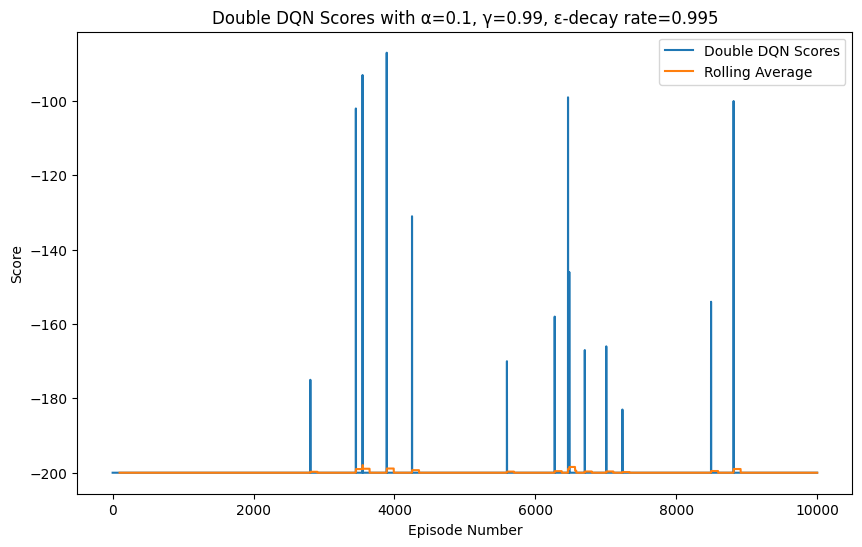

In [23]:
##### Plot scores (rewards) per episode (every 100 episodes) #####
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = double_dqn_scores_series.plot(ax=axes, label="Double DQN Scores")
_ = (double_dqn_scores_series.rolling(window=100)
                      .mean()
                      .rename("Rolling Average")
                      .plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Score")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Double DQN Scores with α=0.1, γ=0.99, ε-decay rate=0.995")

In [24]:
steps_taken_series = pd.Series(steps_taken_list, name="steps_taken")
steps_taken_series.min()

87

In [25]:
total = 0
for i in range(len(double_dqn_scores_series)):
    if double_dqn_scores_series[i] > -200:
      total +=1
print('Successful episodes:', total)

Successful episodes: 14


In [26]:
i_pos = double_dqn_scores_series.values.argmax()
print('Episode number of best score:', i_pos)

Episode number of best score: 3890


In [27]:
double_dqn_scores_series.to_csv('double_dqn_scores.csv', index=False)

In [48]:
from google.colab import files
files.download('double_dqn_scores.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Experiment 2: Parameter variation**

* 3 hidden layers: size 24-48-24
* batch_size: 64
* epsilon_decay: 0.999
* alpha: 0.05
* gamma: 0.99
* Episodes: 10,000
* Buffer size: 100,000
* target update frequency: 10
* Optimizer: Adam - lr =0.03

### Experience Replay Buffer

In [28]:
#Experience replay buffer

_field_names = [
    "state",
    "action",
    "reward",
    "next_state",
    "done"
]
Experience = collections.namedtuple("Experience", field_names=_field_names)

class ExperienceReplayBuffer:

    def __init__(self,
                 batch_size: int,
                 buffer_size: int = None,
                 random_state: np.random.RandomState = None) -> None:

        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer = collections.deque(maxlen=buffer_size)
        self._random_state = np.random.RandomState() if random_state is None else random_state

    def __len__(self) -> int:
        return len(self._buffer)

    @property
    def batch_size(self) -> int:
        return self._batch_size

    @property
    def buffer_size(self) -> int:
        return self._buffer_size

    def append(self, experience: Experience) -> None:
        self._buffer.append(experience)

    def sample(self) -> typing.List[Experience]:
        idxs = self._random_state.randint(len(self._buffer), size=self._batch_size)
        experiences = [self._buffer[idx] for idx in idxs]
        return experiences


### Q-learning update

In [29]:
# Class qnetwork
def select_greedy_actions(states: torch.Tensor, q_network: nn.Module) -> torch.Tensor:
    """Select the greedy action for the current state given some Q-network."""
    _, actions = q_network(states).max(dim=1, keepdim=True)
    return actions


def evaluate_selected_actions(states: torch.Tensor,
                              actions: torch.Tensor,
                              rewards: torch.Tensor,
                              dones: torch.Tensor,
                              gamma: float,
                              q_network: nn.Module) -> torch.Tensor:
    next_q_values = q_network(states).gather(dim=1, index=actions)
    q_values = rewards + (gamma * next_q_values * (1 - dones))
    return q_values


In [30]:
def q_learning_update(states: torch.Tensor,
                      rewards: torch.Tensor,
                      dones: torch.Tensor,
                      gamma: float,
                      q_network: nn.Module) -> torch.Tensor:
    actions = select_greedy_actions(states, q_network)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network)
    return q_values

In [31]:
def double_q_learning_update(states: torch.Tensor,
                             rewards: torch.Tensor,
                             dones: torch.Tensor,
                             gamma: float,
                             q_network_1: nn.Module,
                             q_network_2: nn.Module) -> torch.Tensor:
    actions = select_greedy_actions(states, q_network_1)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network_2)
    return q_values

### Agent Class

In [32]:
class Agent:

    def choose_action(self, state: np.array) -> int:
        raise NotImplementedError

    def learn(self, experiences: typing.List[Experience]) -> None:
        raise NotImplementedError

    def save(self, filepath) -> None:
        raise NotImplementedError

    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        raise NotImplementedError

In [33]:
class DeepQAgent(Agent):

    def __init__(self,
                 state_size: int,
                 action_size: int,
                 optimizer_fn: typing.Callable[[typing.Iterable[nn.Parameter]], optim.Optimizer],
                 batch_size: int,
                 buffer_size: int,
                 epsilon_decay_schedule: typing.Callable[[int], float],
                 alpha: float,
                 gamma: float,
                 update_frequency: int,
                 double_dqn: bool = False,
                 seed: int = None) -> None:

        self._state_size = state_size
        self._action_size = action_size
        self._device = torch.device(("mps") if torch.backends.mps.is_available() else torch.device("cpu"))


        self._random_state = np.random.RandomState() if seed is None else np.random.RandomState(seed)
        if seed is not None:
            torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        _replay_buffer_kwargs = {
            "batch_size": batch_size,
            "buffer_size": buffer_size,
            "random_state": self._random_state
        }
        self._memory = ExperienceReplayBuffer(**_replay_buffer_kwargs)
        self._epsilon_decay_schedule = epsilon_decay_schedule
        self._alpha = alpha
        self._gamma = gamma
        self._double_dqn = double_dqn

        # initialize Q-Networks
        self._update_frequency = update_frequency
        self._online_q_network = self._initialize_q_network()
        self._target_q_network = self._initialize_q_network()
        self._synchronize_q_networks(self._target_q_network, self._online_q_network)
        self._online_q_network.to(self._device)
        self._target_q_network.to(self._device)

        # initialize the optimizer
        self._optimizer = optimizer_fn(self._online_q_network.parameters())

        # initialize some counters
        self._number_episodes = 0
        self._number_timesteps = 0

    def _initialize_q_network(self) -> nn.Module:
        q_network = nn.Sequential(
            nn.Linear(in_features=self._state_size, out_features=24),
            nn.ReLU(),
            nn.Linear(in_features=24, out_features=48),
            nn.ReLU(),
            nn.Linear(in_features=48, out_features=24),
            nn.ReLU(),
            nn.Linear(in_features=24, out_features=self._action_size)
        )
        return q_network

    @staticmethod
    def _soft_update_q_network_parameters(q_network_1: nn.Module,
                                          q_network_2: nn.Module,
                                          alpha: float) -> None:
        for p1, p2 in zip(q_network_1.parameters(), q_network_2.parameters()):
            p1.data.copy_(alpha * p2.data + (1 - alpha) * p1.data)

    @staticmethod
    def _synchronize_q_networks(q_network_1: nn.Module, q_network_2: nn.Module) -> None:
        _ = q_network_1.load_state_dict(q_network_2.state_dict())

    def _uniform_random_policy(self, state: torch.Tensor) -> int:
        return self._random_state.randint(self._action_size)

    def _greedy_policy(self, state: torch.Tensor) -> int:
        action = (self._online_q_network(state).argmax().cpu().item())
        return action

    def _epsilon_greedy_policy(self, state: torch.Tensor, epsilon: float) -> int:
        if self._random_state.random() < epsilon:
            action = self._uniform_random_policy(state)
        else:
            action = self._greedy_policy(state)
        return action

# Modified function
    def choose_action(self, state: np.array) -> int:
      if isinstance(state, tuple):
          state = state[0]
      if isinstance(state, np.float32):
          state = np.array([state])
      if not isinstance(state, np.ndarray):
          state = np.array(state, dtype=np.float32)
      if state.ndim == 1:
          state = np.expand_dims(state, axis=0)

      state_tensor = torch.from_numpy(state).float().to(self._device).unsqueeze(0)

      if not self.has_sufficient_experience():
          action = self._uniform_random_policy(state_tensor)
      else:
          epsilon = self._epsilon_decay_schedule(self._number_episodes)
          action = self._epsilon_greedy_policy(state_tensor, epsilon)

      return action

    def learn(self, experiences: typing.List[Experience]) -> None:
        states, actions, rewards, next_states, dones = (torch.Tensor(vs).to(self._device) for vs in zip(*experiences))
        actions = (actions.long().unsqueeze(dim=1))
        rewards = rewards.unsqueeze(dim=1)
        dones = dones.unsqueeze(dim=1)

        if self._double_dqn:
            target_q_values = double_q_learning_update(next_states,
                                                       rewards,
                                                       dones,
                                                       self._gamma,
                                                       self._online_q_network,
                                                       self._target_q_network)
        else:
            target_q_values = q_learning_update(next_states,
                                                rewards,
                                                dones,
                                                self._gamma,
                                                self._target_q_network)

        online_q_values = (self._online_q_network(states)
                               .gather(dim=1, index=actions))

        # Compute loss function
        loss = F.mse_loss(online_q_values, target_q_values)

        # update network parameters
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()

        self._soft_update_q_network_parameters(self._target_q_network,
                                               self._online_q_network,
                                               self._alpha)

    # Check buffer has enough experiences to start sampling
    def has_sufficient_experience(self) -> bool:
        return len(self._memory) >= self._memory.batch_size

    def save(self, filepath: str) -> None:
        checkpoint = {
            "q-network-state": self._online_q_network.state_dict(),
            "optimizer-state": self._optimizer.state_dict(),
            "agent-hyperparameters": {
                "alpha": self._alpha,
                "batch_size": self._memory.batch_size,
                "buffer_size": self._memory.buffer_size,
                "gamma": self._gamma,
                "update_frequency": self._update_frequency
            }
        }
        torch.save(checkpoint, filepath)

    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        experience = Experience(state, action, reward, next_state, done)
        self._memory.append(experience)

        if done:
            self._number_episodes += 1
        else:
            self._number_timesteps += 1

            # Set frequency i.e. number of steps where agent learns from experiences
            if self._number_timesteps % self._update_frequency == 0 and self.has_sufficient_experience():
                experiences = self._memory.sample()
                self.learn(experiences)


### Train

In [34]:
# Max steps training
def _train_for_at_most(agent: Agent, env: gym.Env, max_timesteps: int) -> int:
    state, _= env.reset()
    score = 0
    # Record number of steps taken by the agent
    steps_taken=0
    for t in range(max_timesteps):
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        steps_taken+=1
        if done:
            break
    return score, steps_taken

# Train until current episode
def _train_until_done(agent: Agent, env: gym.Env) -> float:
    state, _= env.reset()
    score = 0
    steps_taken=0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        steps_taken+=1
    return score, steps_taken

In [35]:
def train(agent: Agent,
          env: gym.Env,
          checkpoint_filepath: str,
          target_score: float,
          number_episodes: int,
          maximum_timesteps=None) -> typing.List[float]:
    scores = []
    steps_taken_list=[]
    # 15,000 size of scores deque
    most_recent_scores = collections.deque(maxlen=15000)
    for i in range(number_episodes):
        if maximum_timesteps is None:
            score, steps_taken = _train_until_done(agent, env)
        else:
            score, steps_taken = _train_for_at_most(agent, env, maximum_timesteps)
        scores.append(score)
        steps_taken_list.append(steps_taken)
        most_recent_scores.append(score)

        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if average_score >= target_score:
            print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            agent.save(checkpoint_filepath)
            break
        # Show reward for every 1,000th episode
        if (i + 1) % 1000 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")

    return scores, steps_taken_list

### Epsilon

In [36]:
def power_decay_schedule(episode_number: int,
                         decay_factor: float,
                         minimum_epsilon: float,
                         max_eps: float) -> float:
    return max(max_eps*decay_factor**episode_number, minimum_epsilon)
# Start with epsilon =1.0 and decay by 0.999
_epsilon_decay_schedule_kwargs = {
    "decay_factor": 0.999,
    "minimum_epsilon": 0.1,
    "max_eps": 1.0
}
epsilon_decay_schedule = lambda n: power_decay_schedule(n, **_epsilon_decay_schedule_kwargs)

### Optimizer

In [37]:
_optimizer_kwargs = {
    "lr": 1e-3,
    "betas": (0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0,
    "amsgrad": False,
}
optimizer_fn = lambda parameters: optim.Adam(parameters, **_optimizer_kwargs)

### Set-up environment and train DQN

In [38]:
# Env MountainCar-v0
env = gym.make("MountainCar-v0")

In [39]:
#Train
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    # 3 actions:
    "action_size": env.action_space.n,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 0.05,
    "gamma": 0.99,
    "update_frequency": 10,
    "double_dqn": True,  # True uses Double DQN
    "seed": None,
}
double_dqn_agent = DeepQAgent(**_agent_kwargs)

In [40]:
steps_taken_list =[]
double_dqn_scores, steps_taken_list = train(double_dqn_agent,
                          env,
                          "double-dqn-checkpoint.pth",
                          number_episodes=10000,
                          target_score=-100,
                          maximum_timesteps=200
                          )

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1000	Average Score: -200.00
Episode 2000	Average Score: -199.96
Episode 3000	Average Score: -199.84
Episode 4000	Average Score: -199.88
Episode 5000	Average Score: -199.63
Episode 6000	Average Score: -195.26
Episode 7000	Average Score: -189.01
Episode 8000	Average Score: -184.34
Episode 9000	Average Score: -179.81
Episode 10000	Average Score: -177.73


In [41]:
# Convert results to series and visualise max, mean std.
double_dqn_scores_series = pd.Series(double_dqn_scores, name="scores")
double_dqn_scores_series.tail(5)

,scores
9995,-200.0
9996,-200.0
9997,-163.0
9998,-200.0
9999,-178.0


In [42]:
double_dqn_scores_series.max()

-85.0

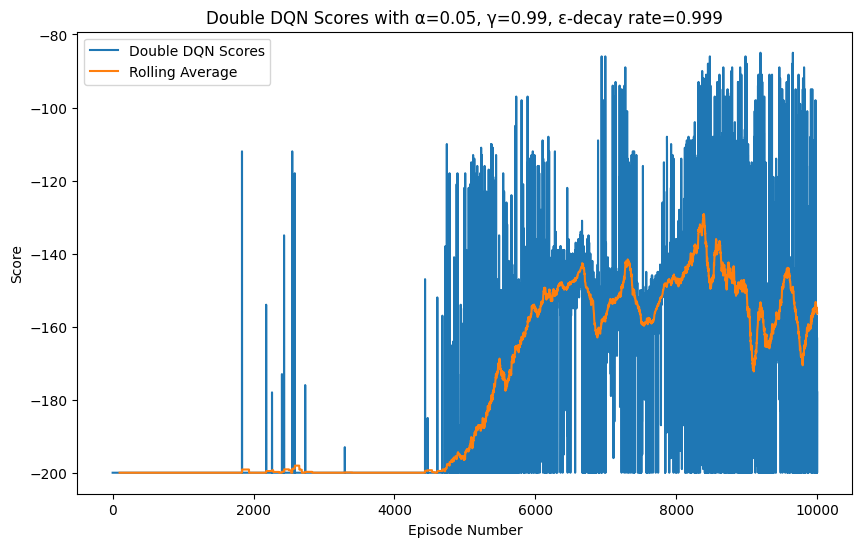

In [43]:
####### Plot scores(rewards) per episode for 100 episodes window #######
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = double_dqn_scores_series.plot(ax=axes, label="Double DQN Scores")
_ = (double_dqn_scores_series.rolling(window=100).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Score")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Double DQN Scores with α=0.05, γ=0.99, ε-decay rate=0.999")

In [44]:
# Minimum steps taken (should be the same as the best score but +ve)
steps_taken_series = pd.Series(steps_taken_list, name="steps_taken")
steps_taken_series.min()

85

In [45]:
# Number of successfull episodes
total = 0
for i in range(len(double_dqn_scores_series)):
    if double_dqn_scores_series[i] > -200:
      total +=1
print('Successful episodes:', total)

Successful episodes: 4313


In [46]:
# Index of best episode
i_pos = double_dqn_scores_series.values.argmax()
print('index Successful episodes:', i_pos)

index Successful episodes: 9194


In [47]:
double_dqn_scores_series[9900:9999].mean()

-156.2020202020202

In [49]:
double_dqn_scores_series.to_csv('double_dqn_two.csv', index=False)

In [50]:
from google.colab import files
files.download('double_dqn_two.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>